# Tutorial 2: Stop detection in trajectories

This notebook shows how to process device-level trajectory data, in different formats, to detect stops using ```nomad```. Stop detection is an important step in
pre-processing trajectory data and in making sense of trajectories by grouping together pings that reflect stationary behavior. The output of stop-detection algorithms is commonly a "stop table", indicating when a stop started, its duration, and a pair of coordinates that approximates the location of the group of pings (typically the centroid). Alternatively, ```nomad``` allows users to retrieve a cluster label for each ping (useful for plotting, for example).

In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
import pygeohash as gh
import geopandas as gpd
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from pyproj import Transformer

In [2]:
import nomad.io.base as loader
import nomad.constants as constants
import nomad.stop_detection.ta_dbscan as DBSCAN
import nomad.stop_detection.lachesis as Lachesis
import nomad.filters as filters
import nomad.city_gen as cg

## Load data sample

For these examples we load some test data from ```nomad``` which has the following trajectory columns. Defining this dictionary beforehands makes the handling of parameters more concise and helps the algorithms know which columns to use. 

In [3]:
traj_cols = {'user_id':'uid',
             'datetime':'local_datetime',
             'latitude':'latitude',
             'longitude':'longitude'}

data = loader.from_file("../nomad/data/gc_sample.csv")

In [4]:
data.head()

,uid,timestamp,latitude,longitude
0,wizardly_joliot,1704119340,38.321711,-36.667334
1,wizardly_joliot,1704119700,38.321676,-36.667365
2,wizardly_joliot,1704155880,38.320959,-36.666748
3,wizardly_joliot,1704156000,38.320936,-36.666739
4,wizardly_joliot,1704156840,38.320924,-36.666747


This synthetic data has records for 100 users for a 1 week period, with spherical coordinates (lat, lon) and datetime format for the time component of each ping. 

### Additional columns 

Nomad allows a degree of flexibility on the input trajectory data used for stop detection (and other algorithms), including common cases like datetime64[ns] formats for the time variable, ISO8601 string formats, or a pandas series with pandas.Timestamp objects. Similarly, it is often the case (and it can speed up stop-detection algorithms) that trajectory data has non-spherical coordinates with units in meters. These are useful for local analyses so that Euclidean distance can be used. 

To demonstrate this flexibility, we create some of these columns with alternative formats. 

In [5]:
# We create a time offset column with different UTC offsets (in seconds)
data['tz_offset'] = 0
data.loc[data.index[:5000],'tz_offset'] = -7200
data.loc[data.index[-5000:], 'tz_offset'] = 3600

# create datetime column as a string
data['local_datetime'] = loader._unix_offset_to_str(data.timestamp, data.tz_offset)
data['local_datetime'] = pd.to_datetime(data['local_datetime'], utc=True)

# create x, y columns in web mercator
gdf = gpd.GeoSeries(gpd.points_from_xy(data.longitude, data.latitude),
                        crs="EPSG:4326")
projected = gdf.to_crs("EPSG:3857")
data['x'] = projected.x
data['y'] = projected.y

data.sample(5)

,uid,timestamp,latitude,longitude,tz_offset,local_datetime,x,y
18736,nervous_thompson,1704852720,38.321430,-36.667558,0,2024-01-10 02:12:00+00:00,-4.081814e+06,4.624933e+06
3273,competent_torvalds,1704604980,38.320457,-36.667499,-7200,2024-01-07 05:23:00+00:00,-4.081807e+06,4.624795e+06
2156,amazing_nightingale,1704377820,38.320246,-36.667821,-7200,2024-01-04 14:17:00+00:00,-4.081843e+06,4.624765e+06
15668,happy_feynman,1704279900,38.320649,-36.667814,0,2024-01-03 11:05:00+00:00,-4.081842e+06,4.624822e+06
17039,mystifying_chebyshev,1704342120,38.320701,-36.666805,0,2024-01-04 04:22:00+00:00,-4.081730e+06,4.624830e+06


## Stop detection algorithms

The stop detection algorithms in ```nomad``` are applied to each user's trajectories separately. Thus, we demonstrate first by sampling a single user's data.

In [6]:
user_sample = data.loc[data.uid == "angry_spence"]
user_sample.head()

,uid,timestamp,latitude,longitude,tz_offset,local_datetime,x,y
24139,angry_spence,1704104460,38.320990,-36.666555,3600,2024-01-01 10:21:00+00:00,-4.081702e+06,4.624871e+06
24140,angry_spence,1704104820,38.320962,-36.666504,3600,2024-01-01 10:27:00+00:00,-4.081697e+06,4.624867e+06
24141,angry_spence,1704104940,38.320955,-36.666495,3600,2024-01-01 10:29:00+00:00,-4.081696e+06,4.624866e+06
24142,angry_spence,1704105540,38.320947,-36.666521,3600,2024-01-01 10:39:00+00:00,-4.081698e+06,4.624865e+06
24143,angry_spence,1704105720,38.320955,-36.666527,3600,2024-01-01 10:42:00+00:00,-4.081699e+06,4.624866e+06


For this user, the trajectory data has 1696 rows (pings) and covers a period of 15 days (start date: 2024-01-01, end date: 2024-01-15). We can visualize this trajectory below:

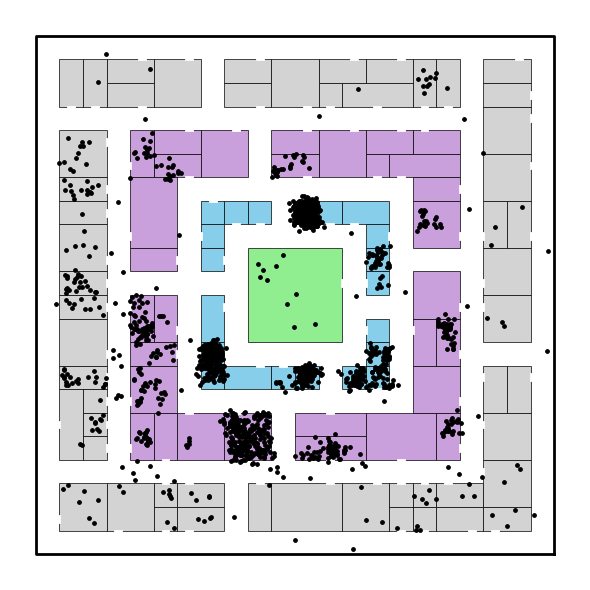

In [7]:
%matplotlib inline

plot_df = user_sample.copy()
transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)
plot_df['x'], plot_df['y'] = transformer.transform(plot_df['latitude'].values, plot_df['longitude'].values)
plot_df['x'] = (plot_df['x'] - 4265699)/15
plot_df['y'] = (plot_df['y'] + 4392976)/15

fig, ax = plt.subplots(figsize=(6, 6))
plt.box(on=False)

# Plotting Pings
ax.scatter(x=plot_df['x'], 
           y=plot_df['y'],
           s=6,
           color='black',
           alpha=1,
           zorder=2)

# Plotting Garden City Map
city = cg.load('garden-city.pkl')
city.plot_city(ax, doors=True, address=False)

ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])

plt.tight_layout()
plt.show()

### Sequential stop detection

The first stop detection algorithm implemented in ```nomad``` is a sequential algorithm insipired by the one in _Project Lachesis: Parsing and Modeling Location Histories_ (Hariharan & Toyama). This algorithm for extracting stays is dependent on two parameters: the roaming distance and the stay duration. 

* Roaming distance represents the maximum distance an object can move away from a point location and still be considered to be staying at that location.
* Stop duration is the minimum amount of time an object must spend within the roaming distance of a location to qualify as a stop.

The algorithm identifies stops as contiguous sequences of pings that stay within the roaming distance for at least the duration of the stop duration.

<div style="text-align: center;">
    <img src="lachesis_algo.png" alt="Lachesis Algorithm" title="Lachesis Algorithm" width="500">
</div>

This algorithm has the following parameters, which determine the size of the resulting stops:
* ```dur_min```: Minimum duration for a stay in minutes.
* ```dt_max```: Maximum time gap permitted between consecutive pings in a stay in minutes (dt_max should be greater than dur_min).
* ```delta_roam```: Maximum roaming distance for a stay in meters.

In [8]:
DUR_MIN = 60
DT_MAX = 120
DELTA_ROAM = 50

The Lachesis algorithm can output a complete table of attributes for identified stops, including the start time, end time, the medoid coordinates, duration, number of pings in the stop, and diameter.

In [9]:
%%time
lachesis_stop_df = Lachesis.lachesis(traj=user_sample,
                                     dur_min=DUR_MIN,
                                     dt_max=DT_MAX,
                                     delta_roam=DELTA_ROAM,
                                     traj_cols=traj_cols,
                                     complete_output=True,
                                     keep_col_names = False,
                                     datetime='local_datetime',
                                     latitude= 'latitude',
                                     longitude='longitude')

lachesis_stop_df.head()

CPU times: user 165 ms, sys: 1.91 ms, total: 167 ms
Wall time: 166 ms


,start_datetime,end_datetime,duration,longitude,latitude,diameter,n_pings,max_gap
0,2024-01-01 15:04:00+00:00,2024-01-01 16:16:00+00:00,72,-36.666470,38.320064,14.691535,14,16
1,2024-01-01 18:17:00+00:00,2024-01-01 20:58:00+00:00,161,-36.667398,38.320415,12.974932,19,59
2,2024-01-01 21:15:00+00:00,2024-01-02 01:10:00+00:00,235,-36.667525,38.321253,13.946715,32,44
3,2024-01-02 05:54:00+00:00,2024-01-02 08:01:00+00:00,127,-36.667489,38.321273,31.460130,17,25
4,2024-01-02 08:40:00+00:00,2024-01-02 11:59:00+00:00,199,-36.667721,38.320554,20.736412,39,21


In [10]:
lachesis_stop_df.columns

Index(['start_datetime', 'end_datetime', 'duration', 'longitude', 'latitude',
       'diameter', 'n_pings', 'max_gap'],
      dtype='object')

An additional argument, ```complete_output```, can be passed to only output the stop start time, duration, and medoid coordinates.

In [11]:
%%time
Lachesis.lachesis(traj=user_sample,
                  dur_min=DUR_MIN,
                  dt_max=DT_MAX,
                  delta_roam=DELTA_ROAM,
                  traj_cols=traj_cols,
                  complete_output=False,
                  keep_col_names = False,
                  datetime='local_datetime',
                  latitude='latitude',
                  longitude='longitude').head()

CPU times: user 162 ms, sys: 1.38 ms, total: 163 ms
Wall time: 163 ms


,start_datetime,duration,longitude,latitude
0,2024-01-01 15:04:00+00:00,72,-36.666470,38.320064
1,2024-01-01 18:17:00+00:00,161,-36.667398,38.320415
2,2024-01-01 21:15:00+00:00,235,-36.667525,38.321253
3,2024-01-02 05:54:00+00:00,127,-36.667489,38.321273
4,2024-01-02 08:40:00+00:00,199,-36.667721,38.320554


We can also get the final cluster label for each of the pings, including those who were identified as noise.

In [12]:
%%time
sample_labels_lach = Lachesis._lachesis_labels(traj=user_sample,
                                               dur_min=DUR_MIN,
                                               dt_max=DT_MAX,
                                               delta_roam=DELTA_ROAM,
                                               traj_cols=traj_cols,
                                               datetime='local_datetime')
sample_labels_lach.sample(n=5)

CPU times: user 44.4 ms, sys: 2.31 ms, total: 46.7 ms
Wall time: 45.5 ms


local_datetime
2024-01-04 17:46:00+00:00    12
2024-01-07 13:13:00+00:00    -1
2024-01-07 03:06:00+00:00    22
2024-01-03 12:16:00+00:00    -1
2024-01-11 18:50:00+00:00    37
dtype: int64

The data could also come with different formats for spatial and temporal variables, the algorithm can handle those situations as well.

In [13]:
%%time
# Lachesis with x, y, and timestamp
Lachesis.lachesis(traj=user_sample,
                  dur_min=DUR_MIN,
                  dt_max=DT_MAX,
                  delta_roam=DELTA_ROAM,
                  traj_cols=traj_cols,
                  complete_output=False,
                  timestamp='timestamp',
                  x='x',
                  y='y').head()

CPU times: user 37.4 ms, sys: 2.85 ms, total: 40.3 ms
Wall time: 38.6 ms


,timestamp,duration,x,y
0,1704121440,72,-4.081693e+06,4.624739e+06
1,1704133020,161,-4.081796e+06,4.624789e+06
2,1704143700,235,-4.081810e+06,4.624908e+06
3,1704174840,127,-4.081806e+06,4.624911e+06
4,1704184800,199,-4.081832e+06,4.624809e+06


Applying these stop detection algorithms to multiple users is straightforward with pandas' ```groupby``` and ```apply``` methods:

In [14]:
mult_users = data.loc[data.uid.isin(["angry_spence", "stoic_almeida", "relaxed_colden", "dazzling_bassi"])]
mult_users.sample(10)

,uid,timestamp,latitude,longitude,tz_offset,local_datetime,x,y
3814,dazzling_bassi,1704896340,38.321597,-36.666669,-7200,2024-01-10 14:19:00+00:00,-4.081715e+06,4.624957e+06
24318,angry_spence,1704270420,38.319631,-36.667540,3600,2024-01-03 08:27:00+00:00,-4.081812e+06,4.624678e+06
24183,angry_spence,1704142260,38.320397,-36.667394,3600,2024-01-01 20:51:00+00:00,-4.081796e+06,4.624787e+06
24804,angry_spence,1704589020,38.321365,-36.667000,3600,2024-01-07 00:57:00+00:00,-4.081752e+06,4.624924e+06
24251,angry_spence,1704187680,38.320575,-36.667732,3600,2024-01-02 09:28:00+00:00,-4.081833e+06,4.624812e+06
24969,angry_spence,1704699780,38.321444,-36.667419,3600,2024-01-08 07:43:00+00:00,-4.081798e+06,4.624935e+06
25120,angry_spence,1704785820,38.320816,-36.667536,3600,2024-01-09 07:37:00+00:00,-4.081811e+06,4.624846e+06
8068,relaxed_colden,1705066260,38.320928,-36.666198,0,2024-01-12 13:31:00+00:00,-4.081663e+06,4.624862e+06
24287,angry_spence,1704205080,38.320303,-36.667819,3600,2024-01-02 14:18:00+00:00,-4.081843e+06,4.624773e+06
8168,relaxed_colden,1705249980,38.320010,-36.666515,0,2024-01-14 16:33:00+00:00,-4.081698e+06,4.624732e+06


In [15]:
%%time
mult_users.groupby(['uid']).apply(lambda x: Lachesis.lachesis(x.reset_index(),
                                                                  dur_min=DUR_MIN,
                                                                  dt_max=DT_MAX,
                                                                  delta_roam=DELTA_ROAM,
                                                                  traj_cols=traj_cols,
                                                                  complete_output=False),include_groups=False)

CPU times: user 55.3 ms, sys: 1.62 ms, total: 56.9 ms
Wall time: 57.5 ms


/Users/andresmondragon/main-stop-detection/nomad/io/base.py:53: UserWarning: Trajectory column 'uid' specified for 'user_id' not found in DataFrame.
  warnings.warn(f"Trajectory column '{value}' specified for '{key}' not found in DataFrame.")
/Users/andresmondragon/main-stop-detection/nomad/io/base.py:53: UserWarning: Trajectory column 'uid' specified for 'user_id' not found in DataFrame.
  warnings.warn(f"Trajectory column '{value}' specified for '{key}' not found in DataFrame.")
/Users/andresmondragon/main-stop-detection/nomad/io/base.py:53: UserWarning: Trajectory column 'uid' specified for 'user_id' not found in DataFrame.
  warnings.warn(f"Trajectory column '{value}' specified for '{key}' not found in DataFrame.")
/Users/andresmondragon/main-stop-detection/nomad/io/base.py:53: UserWarning: Trajectory column 'uid' specified for 'user_id' not found in DataFrame.
  warnings.warn(f"Trajectory column '{value}' specified for '{key}' not found in DataFrame.")


timestamp  duration             x             y
uid                                                              
angry_spence  0  1704121440        72 -4.081693e+06  4.624739e+06
              1  1704133020       161 -4.081796e+06  4.624789e+06
              2  1704143700       235 -4.081810e+06  4.624908e+06
              3  1704174840       127 -4.081806e+06  4.624911e+06
              4  1704184800       199 -4.081832e+06  4.624809e+06
...                     ...       ...           ...           ...
stoic_almeida 1  1704164460       152 -4.081730e+06  4.624811e+06
              2  1704575580        92 -4.081720e+06  4.624798e+06
              3  1704746940       118 -4.081727e+06  4.624819e+06
              4  1705053300       101 -4.081704e+06  4.624736e+06
              5  1705290300       154 -4.081727e+06  4.624818e+06

[87 rows x 4 columns]

We can visualize the identified stops within the city detected by Lachesis for the sample user. Where pings of the same color represent pings belonging to the same cluster/stop and pings in grey are noise.

We can visualize the identified stops within the city detected by Lachesis for the sample user. Where pings of the same color represent pings belonging to the same cluster/stop and pings in grey are noise.

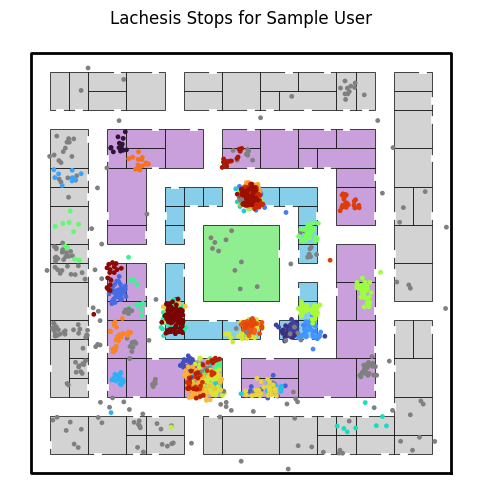

In [16]:
%matplotlib inline

# Merging sample data with labels
merged_data_lach = user_sample.merge(sample_labels_lach.to_frame(name='cluster'), left_on='local_datetime', right_index=True)
transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)
merged_data_lach['x'], merged_data_lach['y'] = transformer.transform(merged_data_lach['latitude'].values, merged_data_lach['longitude'].values)
merged_data_lach['x'] = (merged_data_lach['x'] - 4265699)/15
merged_data_lach['y'] = (merged_data_lach['y'] + 4392976)/15

fig, ax = plt.subplots(figsize=(6, 6))
plt.box(on=False)

# Plotting Garden City Map
city = cg.load('garden-city.pkl')
city.plot_city(ax, doors=True, address=False)

# Getting colors for clusters
unique_clusters = np.sort(merged_data_lach['cluster'].unique())
cluster_mapping = {cluster: i for i, cluster in enumerate(unique_clusters)}
mapped_clusters = merged_data_lach['cluster'].map(cluster_mapping).to_numpy()
cmap_base = plt.get_cmap('turbo', len(unique_clusters) - (1 if -1 in unique_clusters else 0))
colors = ['gray'] + list(cmap_base.colors)
extended_cmap = mcolors.ListedColormap(colors)

# Plotting Pings
ax.scatter(merged_data_lach['x'], 
           merged_data_lach['y'], 
           c=mapped_clusters, 
           cmap=extended_cmap, 
           s=6,
           alpha=1,
           zorder=2)

ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_title("Lachesis Stops for Sample User")
ax.set_xticks([])
ax.set_yticks([])

# plt.savefig('gc_empty.png')
plt.show()

### Density based stop detection (Temporal DBSCAN)

The second stop detection algorithm implemented in ```nomad``` is a time-augmented density-based algorithm, Temporal DBSCAN. This algorithm for clustering user pings combines temporal and spatial dimensions, relying on three key parameters: the time threshold, the distance threshold, and the minimum number of points.

* The time threshold defines the maximum time difference (in minutes) between two consecutive pings for them to be considered neighbors within the same cluster.
* The distance threshold specifies the maximum spatial distance (in meters) between two pings for them to be considered neighbors.
* The minimum points parameter sets the minimum number of points required for a dense region to form a cluster.

If a region contains fewer than minimum number of points required, it is treated as noise. The algorithm identifies clusters by grouping contiguous pings that meet both the temporal and spatial criteria, while also ensuring that each cluster has enough density to be considered valid. Our implementation of Temporal DBSCAN recursively processes the clusters obtained from DBSCAN to address the issue of some clusters overlapping in time.

<div style="text-align: center;">
    <img src="dbscan_algo.png" alt="DBSCAN Algorithm" title="DBSCAN Algorithm" width="500">
</div>

This algorithm has the following parameters, which determine the size of the resulting stops:
* ```time_thresh```: Time threshold in minutes for identifying neighbors.
* ```dist_thresh```: Distance threshold in meters for identifying neighbors.
* ```min_pts```: Minimum number of points required to form a dense region (core point).

In [17]:
TIME_THRESH = 100
DIST_THRESH = 40
MIN_PTS = 10

Similarly to Lachesis, the Temporal DBSCAN algorithm can output a complete table of attributes for identified stops, including the start time, end time, the medoid coordinates, duration, number of pings in the stop, and diameter.

In [18]:
%%time
DBSCAN.temporal_dbscan(user_sample,
                       time_thresh=TIME_THRESH,
                       dist_thresh=DIST_THRESH,
                       min_pts=MIN_PTS,
                       traj_cols=traj_cols,
                       complete_output=True,
                       datetime='local_datetime',
                       latitude='latitude',
                       longitude='longitude').head()

CPU times: user 13.6 s, sys: 584 ms, total: 14.2 s
Wall time: 14.4 s


,start_time,end_time,longitude,latitude,diameter,n_pings,duration,max_gap
cluster,,,,,,,,
0,2024-01-04 16:02:00+00:00,2024-01-04 16:45:00+00:00,-0.639973,0.668841,11.374422,14,43.0,13
1,2024-01-14 19:45:00+00:00,2024-01-15 07:39:00+00:00,-0.639968,0.668818,22.775558,87,714.0,84
2,2024-01-14 14:10:00+00:00,2024-01-14 15:39:00+00:00,-0.639963,0.668810,14.062991,13,89.0,23
3,2024-01-14 01:45:00+00:00,2024-01-14 07:52:00+00:00,-0.639956,0.668827,13.814779,57,367.0,30
4,2024-01-13 13:53:00+00:00,2024-01-13 16:45:00+00:00,-0.639952,0.668824,61.588256,18,172.0,73


The additional argument ```complete_output``` can also be passed to only output the stop start time, duration, and medoid coordinates.

In [19]:
%%time
DBSCAN.temporal_dbscan(user_sample,
                       time_thresh=TIME_THRESH,
                       dist_thresh=DIST_THRESH,
                       min_pts=MIN_PTS,
                       traj_cols=traj_cols,
                       complete_output=False,
                       datetime='local_datetime',
                       latitude='latitude',
                       longitude='longitude').head()

CPU times: user 13.5 s, sys: 472 ms, total: 13.9 s
Wall time: 14 s


,start_time,duration,longitude,latitude
cluster,,,,
0,2024-01-04 16:02:00+00:00,43.0,-0.639973,0.668841
1,2024-01-14 19:45:00+00:00,714.0,-0.639968,0.668818
2,2024-01-14 14:10:00+00:00,89.0,-0.639963,0.668810
3,2024-01-14 01:45:00+00:00,367.0,-0.639956,0.668827
4,2024-01-13 13:53:00+00:00,172.0,-0.639952,0.668824


We can also get the final cluster and core labels for each of the pings.

In [20]:
%%time
sample_labels_dbscan = DBSCAN._temporal_dbscan_labels(user_sample,
                                                      time_thresh=TIME_THRESH,
                                                      dist_thresh=DIST_THRESH,
                                                      min_pts=MIN_PTS,
                                                      traj_cols=traj_cols,
                                                      datetime='local_datetime',
                                                      latitude='latitude',
                                                      longitude='longitude')

sample_labels_dbscan.sample(5)

CPU times: user 13.3 s, sys: 447 ms, total: 13.7 s
Wall time: 13.7 s


,cluster,core
2024-01-14 23:25:00+00:00,1,1
2024-01-04 20:37:00+00:00,35,35
2024-01-08 02:43:00+00:00,24,24
2024-01-09 08:23:00+00:00,-1,-1
2024-01-03 23:08:00+00:00,40,40


The Temporal DBSCAN algorithm also handles data that comes with different formats for spatial and temporal variables.

In [21]:
%%time
# Temporal DBSCAN with x, y, and timestamp
DBSCAN.temporal_dbscan(user_sample,
                       time_thresh=TIME_THRESH,
                       dist_thresh=DIST_THRESH,
                       min_pts=MIN_PTS,
                       traj_cols=traj_cols,
                       complete_output=True,
                       timestamp='timestamp',
                       x='x',
                       y='y').head()

CPU times: user 8.4 s, sys: 594 ms, total: 8.99 s
Wall time: 9.06 s


,start_time,end_time,x,y,diameter,n_pings,duration,max_gap
cluster,,,,,,,,
0,1.704384e+09,1.704387e+09,-4.081836e+06,4.624984e+06,16.842346,14.0,43.0,13.0
1,1.705262e+09,1.705304e+09,-4.081802e+06,4.624791e+06,24.657644,87.0,714.0,84.0
2,1.705241e+09,1.705247e+09,-4.081771e+06,4.624728e+06,15.230095,13.0,89.0,23.0
3,1.705197e+09,1.705219e+09,-4.081725e+06,4.624865e+06,21.113292,57.0,367.0,30.0
4,1.705158e+09,1.705164e+09,-4.081703e+06,4.624845e+06,22.983725,17.0,99.0,19.0


We can also visualize the identified stops within the city detected by DBSCAN for the sample user. Again, pings of the same color represent pings belonging to the same cluster/stop and pings in grey are noise.

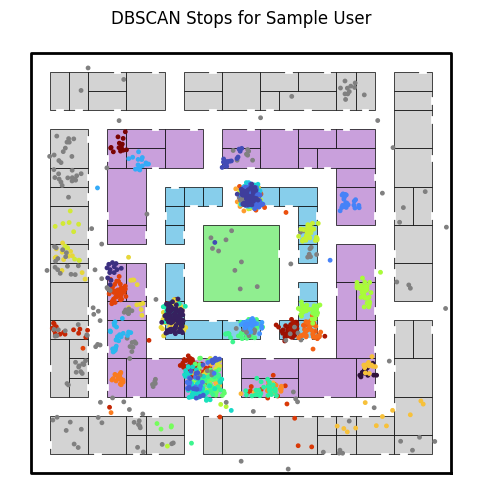

In [22]:
%matplotlib inline

# Merging sample data with labels
merged_data_dbscan = user_sample.merge(sample_labels_dbscan[['cluster']], left_on='local_datetime', right_index=True)
transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)
merged_data_dbscan['x'], merged_data_dbscan['y'] = transformer.transform(merged_data_dbscan['latitude'].values, merged_data_dbscan['longitude'].values)
merged_data_dbscan['x'] = (merged_data_dbscan['x'] - 4265699)/15
merged_data_dbscan['y'] = (merged_data_dbscan['y'] + 4392976)/15

fig, ax = plt.subplots(figsize=(6, 6))
plt.box(on=False)

# Plotting Garden City Map
city = cg.load('garden-city.pkl')
city.plot_city(ax, doors=True, address=False)

# Getting colors for clusters
unique_clusters = sorted(merged_data_dbscan['cluster'].unique())
cluster_mapping = {cluster: i for i, cluster in enumerate(unique_clusters)}
mapped_clusters = merged_data_dbscan['cluster'].map(cluster_mapping).to_numpy()
cmap_base = plt.get_cmap('turbo', len(unique_clusters) - (1 if -1 in unique_clusters else 0))
colors = ['gray'] + list(cmap_base.colors)
extended_cmap = mcolors.ListedColormap(colors)

# Plotting Pings
ax.scatter(merged_data_dbscan['x'], 
           merged_data_dbscan['y'], 
           c=mapped_clusters, 
           cmap=extended_cmap, 
           s=6,
           alpha=1,
           zorder=2)

ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_title("DBSCAN Stops for Sample User")
ax.set_xticks([])
ax.set_yticks([])

# plt.savefig('gc_empty.png')
plt.show()